# [과제4] 이미지 왜곡 제거 오토인코더 제작

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Conv2DTranspose, concatenate
from keras.models import Sequential, Model
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image
from PIL import Image
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [3]:
data = np.load('.npzs/pfcn.npz')

train_images = data['train_images']
test_images = data['test_images']
train_mattes = data['train_mattes']
test_mattes = data['test_mattes']

In [4]:
np.shape(train_images), np.shape(test_images), np.shape(
    train_mattes), np.shape(test_mattes)

((1700, 100, 75, 3), (300, 100, 75, 3), (1700, 100, 75), (300, 100, 75))

In [5]:
y = np.concatenate([train_images, test_images])

In [6]:
np.shape(y)

(2000, 100, 75, 3)

In [7]:
import os

base = '.distortion'

if not os.path.exists(base):
    os.mkdir(base)

before = base + '/before'
after = base + '/after'

if not os.path.exists(before):
    os.mkdir(before)

if not os.path.exists(after):
    os.mkdir(after)

In [8]:
cnt = 1
for a in y:
    new_arr = ((a - a.min()) * (1 / (a.max() - a.min()) * 255)).astype('uint8')
    im = Image.fromarray(new_arr)
    im.save(f'{before}/{cnt}.jpg')
    cnt += 1

In [9]:
from wand.image import Image
import numpy as np
import cv2

cnt = 1
for _ in range(2000):
    with Image(filename=f'{before}/{cnt}.jpg') as img:
        img.virtual_pixel = 'transparent'
        img.distort('barrel', (0.2, 0.0, 0.0, 1.0))
        img.save(filename=f'{after}/{cnt}.jpg')

    cnt += 1

In [10]:
from PIL import Image

result = []
cnt = 1
for _ in range(2000):
    img = Image.open(f'{after}/{cnt}.jpg').convert('RGB')
    img = np.array(img)
    img = img / 255.
    result.append(img)
    cnt += 1

X = np.array(result)

In [11]:
np.shape(X), np.shape(y)

((2000, 100, 75, 3), (2000, 100, 75, 3))

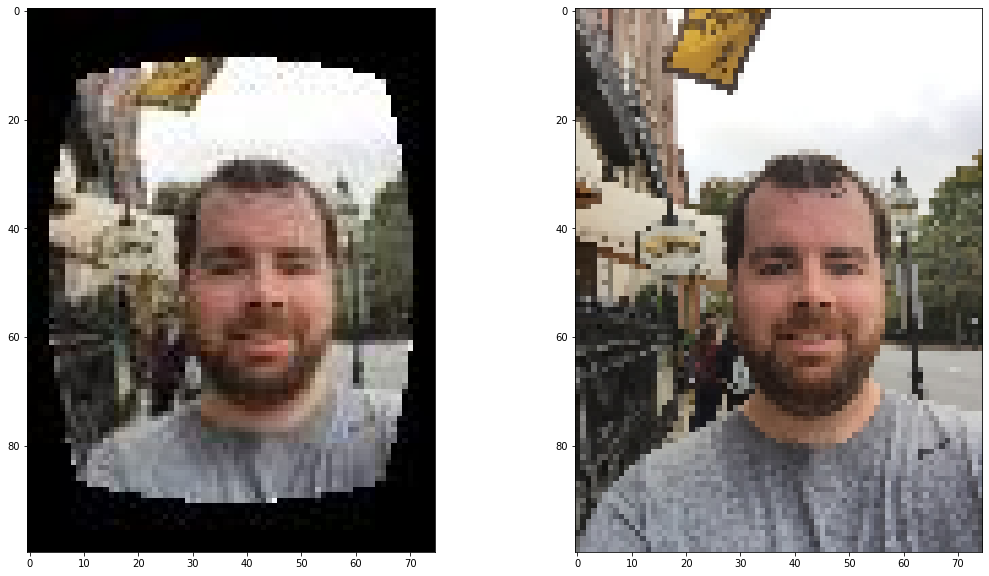

In [12]:
plt.figure(figsize=(18, 10))

plt.subplot(1, 2, 1)
plt.imshow(X[1])

plt.subplot(1, 2, 2)
plt.imshow(y[1])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=SEED)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 100, 75, 3), (400, 100, 75, 3), (1600, 100, 75, 3), (400, 100, 75, 3))

In [15]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [16]:
def unet_like():
    inputs = Input((100, 75, 3))

    c0 = conv2d_block(inputs, 8)
    p0 = MaxPool2D(2)(c0)
    p0 = Dropout(0.1)(p0)

    c1 = conv2d_block(p0, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2)(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(0, 1))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(1, 0))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0, 1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    u10 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0, 1))(c9)
    outputs = Conv2D(3, 1, activation="sigmoid")(u10)

    model = Model(inputs, outputs)

    return model

In [17]:
model_unet = unet_like()
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 75, 8)   224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 8)   32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 8)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
model_unet.compile(loss="mae", optimizer="adam", metrics=["accuracy"])

In [19]:
hist = model_unet.fit(X_train,
                      y_train,
                      validation_data=(X_test, y_test),
                      epochs=30)

Epoch 1/30
50/50 [==============================] - 16s 57ms/step - loss: 0.1870 - accuracy: 0.4757 - val_loss: 0.1958 - val_accuracy: 0.6461
Epoch 2/30
50/50 [==============================] - 1s 28ms/step - loss: 0.1128 - accuracy: 0.6304 - val_loss: 0.1565 - val_accuracy: 0.6804
Epoch 3/30
50/50 [==============================] - 1s 27ms/step - loss: 0.1017 - accuracy: 0.6537 - val_loss: 0.1379 - val_accuracy: 0.6418
Epoch 4/30
50/50 [==============================] - 1s 27ms/step - loss: 0.0976 - accuracy: 0.6885 - val_loss: 0.1249 - val_accuracy: 0.6631
Epoch 5/30
50/50 [==============================] - 1s 28ms/step - loss: 0.0928 - accuracy: 0.7183 - val_loss: 0.1090 - val_accuracy: 0.6793
Epoch 6/30
50/50 [==============================] - 1s 26ms/step - loss: 0.0898 - accuracy: 0.7286 - val_loss: 0.1032 - val_accuracy: 0.6784
Epoch 7/30
50/50 [==============================] - 1s 25ms/step - loss: 0.0887 - accuracy: 0.7357 - val_loss: 0.0926 - val_accuracy: 0.6969
Epoch 8/30
5

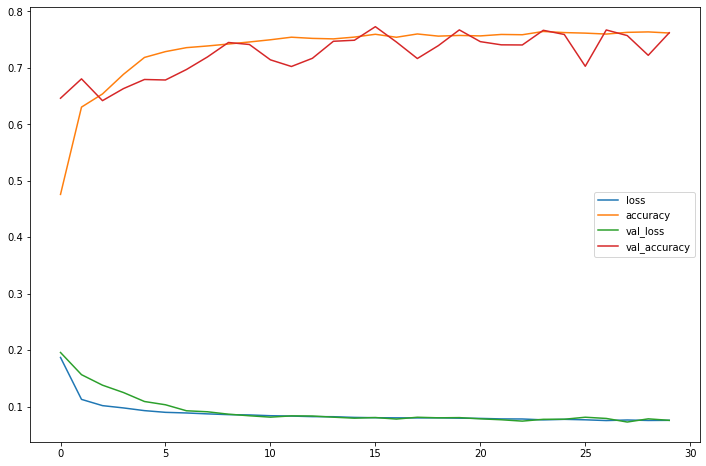

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

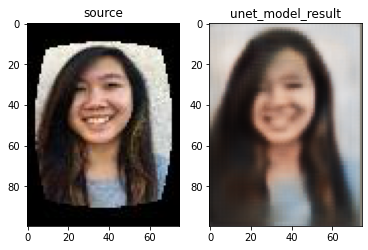

In [21]:
result = model_unet.predict(X_test[3:4])

plt.subplot(1, 2, 1)
plt.title('source')
plt.imshow(X_test[3])

plt.subplot(1, 2, 2)
plt.title('unet_model_result')
plt.imshow(result[0])